<a href="https://colab.research.google.com/github/dataexpert-moon/class_ai4dl/blob/demo-repo/week11/chapter10_dl_for_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-05-15 08:14:29--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.40.142, 52.217.128.144, 52.217.71.118, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.40.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  43.8MB/s    in 0.3s    

2023-05-15 08:14:30 (43.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

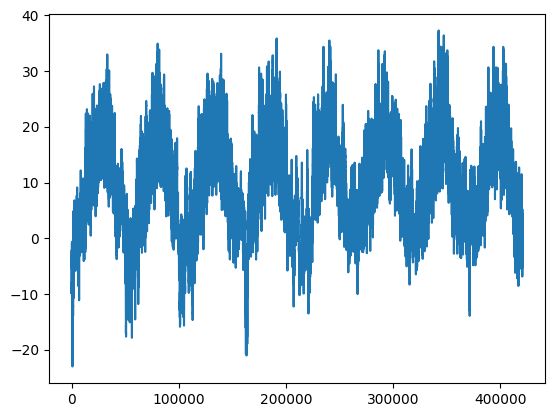

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

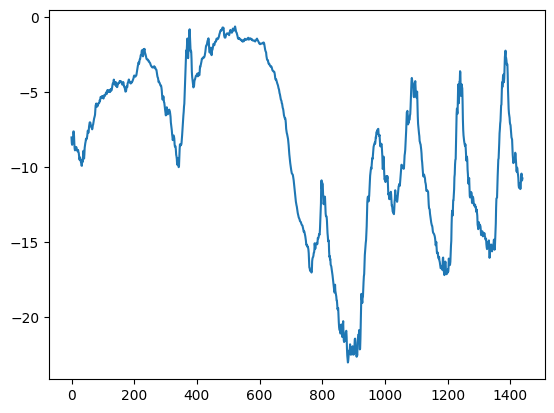

In [5]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [10]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [11]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 56s 63ms/step - loss: 12.9103 - mae: 2.7712 - val_loss: 10.3333 - val_mae: 2.5386
Epoch 2/10
819/819 [==============================] - 43s 53ms/step - loss: 9.0668 - mae: 2.3744 - val_loss: 12.3465 - val_mae: 2.7726
Epoch 3/10
819/819 [==============================] - 41s 50ms/step - loss: 8.3597 - mae: 2.2826 - val_loss: 11.7896 - val_mae: 2.7201
Epoch 4/10
819/819 [==============================] - 42s 51ms/step - loss: 7.9105 - mae: 2.2255 - val_loss: 11.3818 - val_mae: 2.6619
Epoch 5/10
819/819 [==============================] - 46s 57ms/step - loss: 7.5872 - mae: 2.1790 - val_loss: 10.8740 - val_mae: 2.6115
Epoch 6/10
819/819 [==============================] - 50s 61ms/step - loss: 7.3616 - mae: 2.1486 - val_loss: 11.8633 - val_mae: 2.7405
Epoch 7/10
819/819 [==============================] - 49s 60ms/step - loss: 7.1850 - mae: 2.1218 - val_loss: 11.5959 - val_mae: 2.7034
Epoch 8/10
819/819 [==============================] - 

**Plotting results**

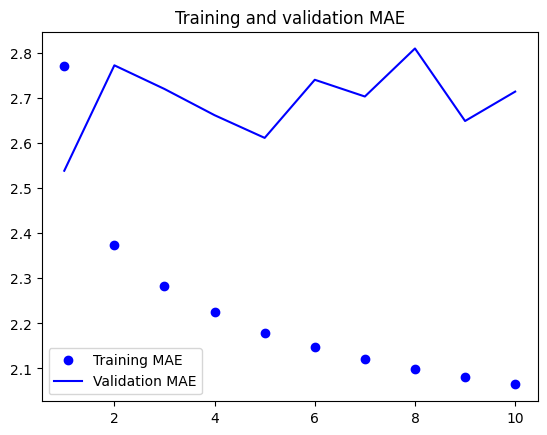

In [13]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 49s 53ms/step - loss: 23.4847 - mae: 3.7797 - val_loss: 15.9239 - val_mae: 3.1508
Epoch 2/10
819/819 [==============================] - 50s 60ms/step - loss: 15.7193 - mae: 3.1500 - val_loss: 15.8988 - val_mae: 3.1354
Epoch 3/10
819/819 [==============================] - 43s 52ms/step - loss: 14.3012 - mae: 3.0006 - val_loss: 14.2299 - val_mae: 2.9802
Epoch 4/10
819/819 [==============================] - 44s 53ms/step - loss: 13.4662 - mae: 2.9046 - val_loss: 15.4235 - val_mae: 3.1287
Epoch 5/10
819/819 [==============================] - 46s 56ms/step - loss: 12.8054 - mae: 2.8330 - val_loss: 15.5227 - val_mae: 3.0986
Epoch 6/10
819/819 [==============================] - 46s 56ms/step - loss: 12.2420 - mae: 2.7706 - val_loss: 15.0615 - val_mae: 3.0828
Epoch 7/10
819/819 [==============================] - 52s 64ms/step - loss: 11.7615 - mae: 2.7117 - val_loss: 16.0409 - val_mae: 3.1649
Epoch 8/10
819/819 [============================

### A first recurrent baseline

**A simple LSTM-based model**

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 51s 57ms/step - loss: 41.5320 - mae: 4.6950 - val_loss: 13.0225 - val_mae: 2.7471
Epoch 2/10
819/819 [==============================] - 54s 66ms/step - loss: 11.0058 - mae: 2.5779 - val_loss: 9.6888 - val_mae: 2.4333
Epoch 3/10
819/819 [==============================] - 54s 65ms/step - loss: 9.8749 - mae: 2.4504 - val_loss: 9.7304 - val_mae: 2.4351
Epoch 4/10
819/819 [==============================] - 53s 65ms/step - loss: 9.4408 - mae: 2.3979 - val_loss: 9.7023 - val_mae: 2.4253
Epoch 5/10
819/819 [==============================] - 44s 53ms/step - loss: 9.1520 - mae: 2.3622 - val_loss: 9.6852 - val_mae: 2.4143
Epoch 6/10
819/819 [==============================] - 45s 54ms/step - loss: 8.9070 - mae: 2.3294 - val_loss: 9.9991 - val_mae: 2.4468
Epoch 7/10
819/819 [==============================] - 45s 54ms/step - loss: 8.7384 - mae: 2.3041 - val_loss: 9.9839 - val_mae: 2.4424
Epoch 8/10
819/819 [==============================] - 52s 6

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [16]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [17]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [18]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [19]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [20]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 401s 486ms/step - loss: 29.9261 - mae: 4.0199 - val_loss: 9.6182 - val_mae: 2.4185
Epoch 2/50
819/819 [==============================] - 394s 481ms/step - loss: 14.8418 - mae: 2.9917 - val_loss: 9.3768 - val_mae: 2.3843
Epoch 3/50
819/819 [==============================] - 390s 476ms/step - loss: 14.0102 - mae: 2.9039 - val_loss: 9.0555 - val_mae: 2.3316
Epoch 4/50
819/819 [==============================] - 392s 477ms/step - loss: 13.4010 - mae: 2.8376 - val_loss: 9.1721 - val_mae: 2.3435
Epoch 5/50
819/819 [==============================] - 391s 477ms/step - loss: 12.8674 - mae: 2.7833 - val_loss: 9.5791 - val_mae: 2.3984
Epoch 6/50
819/819 [==============================] - 396s 483ms/step - loss: 12.3715 - mae: 2.7282 - val_loss: 9.3422 - val_mae: 2.3702
Epoch 7/50
819/819 [==============================] - 395s 481ms/step - loss: 12.0039 - mae: 2.6887 - val_loss: 9.2884 - val_mae: 2.3713
Epoch 8/50
819/819 [=====================

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

### Going even further

## Summary